In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
import random
%matplotlib inline
import shutil
import tensorflow.contrib.learn as tflearn
import tensorflow.contrib.layers as tflayers
from tensorflow.contrib.learn.python.learn import learn_runner
import tensorflow.contrib.metrics as metrics
import tensorflow.contrib.rnn as run

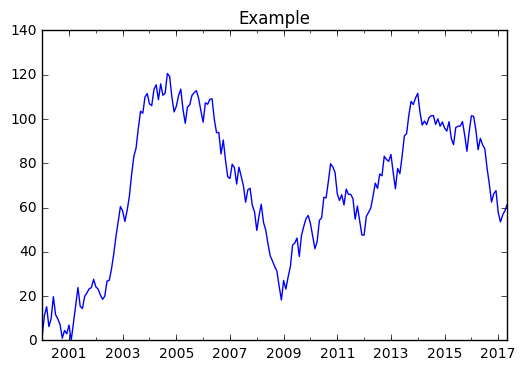

In [2]:
random.seed(100)
rng = pd.date_range(start='2000', periods =209,freq='M')
ts = pd.Series(np.random.uniform(-10,10,size=len(rng)),rng).cumsum()
ts.plot(c='b', title="Example")
plt.show()

In [3]:
ts.head(10)

2000-01-31     1.897425
2000-02-29    11.307990
2000-03-31    15.232792
2000-04-30     6.247480
2000-05-31     9.845846
2000-06-30    19.760862
2000-07-31    11.624841
2000-08-31     9.742425
2000-09-30     7.157436
2000-10-31     0.995948
Freq: M, dtype: float64

In [4]:
TS = np.array(ts)
num_periods = 20  # 10 batches , 20 values per batch
f_horizon = 1  # Forecast Horizon, 1 period into future

x_data = TS[:(len(TS)-(len(TS) % num_periods))]    #x_data len is truncated from 209 to 200
x_batches = x_data.reshape(-1,20,1)

y_data = TS[1:(len(TS)-len(TS) % num_periods)+f_horizon]
y_batches = y_data.reshape(-1,20,1)


print(len(x_batches))
print(x_batches.shape)
print(x_batches[0:1])

print(y_batches.shape)
print(y_batches[0:1])


10
(10, 20, 1)
[[[  1.89742484]
  [ 11.30798974]
  [ 15.23279241]
  [  6.24748048]
  [  9.84584644]
  [ 19.76086173]
  [ 11.62484131]
  [  9.74242527]
  [  7.15743636]
  [  0.99594764]
  [  4.52300958]
  [  3.01364628]
  [  6.94141996]
  [  0.07114362]
  [  8.027211  ]
  [ 15.7337816 ]
  [ 23.88059144]
  [ 15.47129822]
  [ 14.37843759]
  [ 19.91388049]]]
(10, 20, 1)
[[[ 11.30798974]
  [ 15.23279241]
  [  6.24748048]
  [  9.84584644]
  [ 19.76086173]
  [ 11.62484131]
  [  9.74242527]
  [  7.15743636]
  [  0.99594764]
  [  4.52300958]
  [  3.01364628]
  [  6.94141996]
  [  0.07114362]
  [  8.027211  ]
  [ 15.7337816 ]
  [ 23.88059144]
  [ 15.47129822]
  [ 14.37843759]
  [ 19.91388049]
  [ 21.43171046]]]


In [5]:
def test_data(series, forecast, num_periods):
    test_x_setup = TS[-(num_periods+forecast):]
    testX = test_x_setup[:num_periods].reshape(-1,20,1)
    testY = TS[-(num_periods):].reshape(-1,20,1)
    return testX, testY

In [6]:
X_test, Y_test = test_data(TS, f_horizon, num_periods)
print(X_test.shape)
print(X_test)
print(Y_test.shape)
print(Y_test)

(1, 20, 1)
[[[  98.84949165]
  [  92.71270293]
  [  85.44393039]
  [  94.38578174]
  [ 101.45883835]
  [ 101.17726902]
  [  94.99281899]
  [  86.12641899]
  [  91.271071  ]
  [  88.36444004]
  [  86.50958113]
  [  77.92995455]
  [  70.64467864]
  [  62.50416101]
  [  66.30101712]
  [  67.65221891]
  [  57.76316306]
  [  53.49751889]
  [  56.74370161]
  [  58.58125417]]]
(1, 20, 1)
[[[  92.71270293]
  [  85.44393039]
  [  94.38578174]
  [ 101.45883835]
  [ 101.17726902]
  [  94.99281899]
  [  86.12641899]
  [  91.271071  ]
  [  88.36444004]
  [  86.50958113]
  [  77.92995455]
  [  70.64467864]
  [  62.50416101]
  [  66.30101712]
  [  67.65221891]
  [  57.76316306]
  [  53.49751889]
  [  56.74370161]
  [  58.58125417]
  [  61.38199584]]]


In [7]:
tf.reset_default_graph()

num_periods = 20  #number of periods per vector used to predict one period ahead
inputs = 1        #number of vectors submitted 
hidden = 100      #number of neurons we will recursively work through
output = 1        #number of output vector

X = tf.placeholder(tf.float32, [None, num_periods, inputs ])
y = tf.placeholder(tf.float32, [None, num_periods, output ])

basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=hidden, activation=tf.nn.relu)
rnn_output, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32)   # dynamic instead of static

learning_rate =0.001

stacked_rnn_output = tf.reshape(rnn_output,[-1, hidden])     # changed the form into a tensor
stacked_outputs = tf.layers.dense(stacked_rnn_output, output)  # GD
outputs = tf.reshape(stacked_outputs, [-1, num_periods, output]) # shape of the results

loss = tf.reduce_sum(tf.square(outputs - y))
optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()




In [8]:
epochs = 2000

with tf.Session() as sess:
    init.run()
    for i in range(epochs):
        sess.run(training_op, feed_dict={X: x_batches, y:y_batches})
        if i % 100 == 0:
            mse = loss.eval(feed_dict={X:x_batches, y:y_batches})
            print(i, "\tMSE:", mse)
    y_pred = sess.run(outputs, feed_dict={X: X_test})
    print(y_pred)
        


0 	MSE: 765409.0
100 	MSE: 31162.0
200 	MSE: 11401.0
300 	MSE: 3076.98
400 	MSE: 1941.4
500 	MSE: 1671.25
600 	MSE: 1485.69
700 	MSE: 1352.48
800 	MSE: 1289.83
900 	MSE: 1219.85
1000 	MSE: 1189.04
1100 	MSE: 1105.01
1200 	MSE: 1066.83
1300 	MSE: 1076.05
1400 	MSE: 1021.56
1500 	MSE: 990.767
1600 	MSE: 965.231
1700 	MSE: 944.076
1800 	MSE: 927.123
1900 	MSE: 902.526
[[[ 102.64790344]
  [  90.19619751]
  [  79.13625336]
  [ 100.20591736]
  [ 108.88659668]
  [ 118.10102081]
  [  75.19831085]
  [  96.13349152]
  [  90.03050232]
  [ 101.9127121 ]
  [  80.56259918]
  [  68.80857849]
  [  76.04837036]
  [  51.8703804 ]
  [  54.37711334]
  [  72.14997864]
  [  66.655159  ]
  [  55.82453537]
  [  51.15909195]
  [  70.43699646]]]


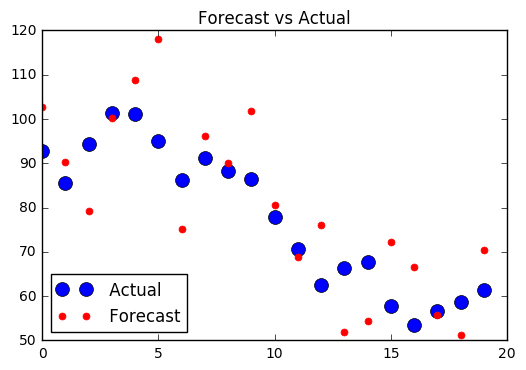

In [9]:
plt.title("Forecast vs Actual")

plt.plot(pd.Series(np.ravel(Y_test)),"bo", markersize=10, label =" Actual")
plt.plot(pd.Series(np.ravel(y_pred)),"r.", markersize=10, label =" Forecast")
plt.legend(loc="lower left")

plt.show()